In [1]:
%run '../definitions.ipynb'

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import zipfile
import zlib
import os
import gc

class XAMSRaw():
    '''
    New in version 1: just one channel, separate array for waveforms
    '''
    __version__ = '1.0.0'
    base_dir = ''
    filenames = []
    # d: dataframe for properties
    df = None
    # d: array for data.
    d = None
    channel = -1
    
    ###################### Initialization and data loading
    def __init__(self, data_dir, run_name, channel, pickle_dir = '/home/erik/win/data/xams_run8/single_e_waveforms/'):
        self.run_name = run_name
        self.base_dir = os.path.join(data_dir, run_name)
        self.pickle_dir = os.path.join(pickle_dir, run_name)
        self.filenames = os.listdir(self.base_dir)
        self.filenames = [_f for _f in self.filenames if _f[-4:] == '.zip']
        self.channel = channel
        self.d = np.array([])
        self.df = pd.DataFrame()
        
        if not os.path.exists(self.pickle_dir):
            print('Making new pickle directory')
            os.makedirs(self.pickle_dir)
        
        return
    
    def load_one(self, number=0):
        file_path = os.path.join(self.base_dir, self.filenames[number])
        pulse_list = self._read_pulses_in_file(file_path, channel)
        self.d = np.array(pulse_list)
        return
    
    def load_all(self, stop_after = np.inf, from_pickle = True, to_pickle = True, verbose = False):
        # Check if we already have data, if so, throw it out
        if len(self.d) > 0:
            print('You already loaded data, I will remove that now!')
            self.d = np.array()
        # Lists to contain all pulses
        pulse_list = []
        
        # Loop over .zip files
        for filename in tqdm(self.filenames[:stop_after]):
            file_path = os.path.join(self.base_dir, filename)
            # Get filename and full path to pickle
            pickle_filename = filename.replace('.zip', '_waveforms_ch%d.pickle' % (self.channel))
            pickle_path = os.path.join(self.pickle_dir, pickle_filename)
            if from_pickle:
                # Check if we have a correspoding pickle file
                if os.path.isfile(pickle_path):
                    _pulse_list = pickle.load(open(pickle_path, 'rb'))
                else:
                    _pulse_list = self._read_pulses_in_file(file_path, self.channel)
            else:
                _pulse_list = self._read_pulses_in_file(file_path, self.channel)
            pulse_list = pulse_list + _pulse_list
            
            if to_pickle and not os.path.isfile(pickle_path):
                pickle.dump(_pulse_list, open(pickle_path, 'wb'))
            
        self.d = np.array(pulse_list, dtype=float)
        print('Read %d events' % len(self.d))
        return
                   
    ###################### Basic processing
    # All `compute_` functions add one or more variable to the dataframe
    # All `correct_` functions will change the waveform (and also the `invert` one, incidentally)    
    def compute_baselines(self, baseline_bounds = (0, 300), mode='average'):
        '''
        Compute the baseline by using the waveform within a certain range.
        Modes enabled: `average`.
        '''
        
        self.df['baseline'] = self._get_baseline(baseline_bounds, mode)
        return
        
    def compute_baselines_double(self, baseline_bounds_0, baseline_bounds_1, mode='average'):
        '''
        Compute the baseline in two stretches (`left` and `right`). 
        Also adds the average bin number of left and right stretch.
        Can be used for baseline interpolation (to get rid of LF noise)
        '''      
        baselines_0_1 = []
        for baseline_bounds in (baseline_bounds_0, baseline_bounds_1):
            baselines_0_1.append(self._get_baseline(baseline_bounds, mode))
        self.df['baseline_left'] = baselines_0_1[0]
        self.df['baseline_right'] = baselines_0_1[1]
        self.df['baseline_left_mean_sample'] = 0.5 * (baseline_bounds_0[0] + baseline_bounds_0[1])
        self.df['baseline_right_mean_sample'] = 0.5 * (baseline_bounds_1[0] + baseline_bounds_1[1])   
        return

    def compute_area(self, area_bounds = (325, 375)):
        '''
        Compute the area within certain bounds, as well as the total area in the pulse and their ratio.
        '''
        left, right = area_bounds
        self.df['area'] = np.sum(self.d[:, left:right], axis=1)
        self.df['area_total'] = np.sum(self.d, axis=1)
        self.df['area_fraction_in_bounds'] = self.df['area'] / self.df['area_total']
        return
    
    def compute_max(self, area_bounds = (325, 375)):
        left, right = area_bounds
        
        self.df['max_index'] = np.argmax(self.d[:, left:right], axis = 1) + left
        self.df['max'] = np.max(self.d[:, left:right], axis = 1)
        self.df['max_total'] = np.max(self.d, axis = 1)
        return
    
    def compute_noise_level(self, area_bounds):
        '''
        Compute the noise level (std) in the waveform left of area bounds.
        '''
        left, right = area_bounds
        self.df['noise'] = np.std(self.d[:, left:], axis = 1)
        return
    
    def correct_pulse_baseline_linear_interpolation(self):
        '''
        Correct baseline by linearly interpolating the data between two points.
        '''
        n_samples = len(self.d[0])
        slope = ((self.df['baseline_right'] - self.df['baseline_left']) / 
                   (self.df['baseline_right_mean_sample'] - self.df['baseline_left_mean_sample']))
        offset = self.df['baseline_left'] - slope * self.df['baseline_left_mean_sample']
        x_axis = np.arange(n_samples)
        for i in tqdm(range(len(self.d)), desc = 'Subtracting baseline '):
            self.d[i] = self.d[i] - (x_axis * slope[i] + np.ones(n_samples) * offset[i])
        return
    
    def invert_pulse(self):
        '''
        Invert all the values in the pulse so that PMT peaks are positive.
        
        '''
        self.d = - self.d
        return
    
    def correct_area(self, gain):
        '''
        Convert area from A.U (actually adc-count times 2 ns) to electrons
        '''
        self.df['area'] = self.df['area']  * 1/(2**14) * 0.5 * 2 * 1 / 50 * 1e-9 * 1 / (1.6022e-19) / gain
        return
    
    ###################### Main analysis
    
    def cut_area(self, cut_area_bounds, verbose = True):
        '''
        Cut pulses from the dataframe based on their area.
        '''
        area_min, area_max = cut_area_bounds
        sel = np.array((self.df['area'] > area_min) & (self.df['area'] < area_max))
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.d), 100 * sum(sel) / len(self.d)))
        self.d = self.d[sel]
        self.df = self.df[sel]
        return 
    
    def cut_max(self, cut_max_bounds, verbose=True):
        '''
        Cut pulses from the dataframe based on their maximum.
        '''
        amp_min, amp_max = cut_max_bounds
        sel = np.array((self.df['max'] > amp_min) & (self.df['max'] < amp_max))
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.d), 100 * sum(sel) / len(self.d)))
        self.d = self.d[sel]
        self.df = self.df[sel]
        return    
    
    def cut_noise(self, noise_max, verbose = True):
        '''
        Cut pulses with high std in waveform
        '''
        sel = np.array((self.df['noise'] < noise_max))
        if verbose: print('Selected %d of %d events (%.2f %%)' % 
                  (sum(sel), len(self.d), 100 * sum(sel) / len(self.d)))
        self.d = self.d[sel]
        self.df = self.df[sel]
        return
    
    def get_average_pulse(self, normalize=True, align_on = 'max_index', alignment_bin = 340):
        '''
        Align the pulses in the dataframe, normalize them, compute the average waveform.
        That's it. Normalization of pulses can be turned of, but don't (I guess?). Aligns on `alignment_bin`. 
        Align on `max_index` is the only alignment implemented so far.
        if `align_on = None' there will be NO alignment (but `max_index` still needs to exist, yes, crappy programming)
        '''
        # Hmm. Ugly hard-coded time array.
        time_edges = np.linspace(0, 2*640, 641)
        # Set time bin 0 to 0 ns.
        time_bins  = time_edges[:-1]
        
        time_entries = []
        weight_entries = []
        for pulse, area, alignment_entry in zip(self.d, self.df['area'], self.df[align_on]):
            # Fill histogram, this allows to shift time by arbitrary number.
            pulse = pulse / area
            time, pulse = self._shift_waveform(time_bins, pulse, align_on, alignment_entry, alignment_bin)
            time_entries.append(time)
            weight_entries.append(pulse)
        time_entries = np.concatenate(time_entries)
        weight_entries = np.concatenate(weight_entries)
        
        avg_pulse, _ = np.histogram(time_entries, bins = time_edges, weights=weight_entries)
        # Normalize based on number of waveform. Since all composite
        # waveforms are normalized, this normalizes the lot.
        avg_pulse = 1/len(self.d) * avg_pulse
        return time_bins, avg_pulse
       
    ###################### Plotting functions
    def plot_waveform(self, i, normalize=True, align_on = 'max_index', alignment_bin = 340, **kwargs):
        '''
        Plot a single waveform at position i for channel `channel`. May be aligned by your arguments. 
        kwargs passed to plt.plot
        '''
        pulse = self.d[i]
        if normalize:
            pulse = pulse / self.df['area'].iloc[i]
        time = np.linspace(0, 2*639, 640)
        if align_on == 'max_index':
            alignment_entry = self.df[align_on].iloc[i]
        else:
            alignment_entry = None
        time, pulse = self._shift_waveform(time, pulse, align_on, alignment_entry, alignment_bin)
        plt.plot(time, pulse, **kwargs)
        return 
    
    def plot_area_spectrum(self, area_bounds = [], **kwargs):
        plt.hist(self.df['area'], **kwargs)
        for _l in area_bounds:
            plt.axvline(_l, ls='--', color='red', lw=1.5)
        plt.yscale('log')
        plt.xlabel('Pulse area (p.e.)')
        plt.ylabel('Counts')
        return
        
    ###################### Subroutines called by other functions in class (all start with _ )
        
    def _get_baseline(self, baseline_bounds, mode):
        '''
        Compute the baseline in between two bounds for one channel.
        '''
        left, right = baseline_bounds
        if mode == 'average':
            return np.average(self.d[:, left:right], axis=1)
        else:
            raise NotImplementedError('Baseline mode %s not implemented.' % mode)
        
    def _read_pulses_in_file(self, filename, channel):
        file = zipfile.ZipFile(filename, "r" )
        pulse_list = []
        # Parse file name
        min_event = int(filename.split(sep = '-')[-3])
        max_event = int(filename.split(sep = '-')[-2])
        
        for event_number in range(min_event, max_event + 1):
            with file.open('%d' % event_number) as event_in_zip:
                data = event_in_zip.read()
                data = zlib.decompress(data)
                ev = pickle.loads(data)
                pulse_list.append(ev.pulses[channel].raw_data)
        return pulse_list
    
    def _shift_waveform(self, time_bins, pulse, align_on, alignment_entry, alignment_bin):
        if align_on is None:
            time = time_bins 
        elif align_on is 'max_index':
            time = time_bins - alignment_entry * 2. + alignment_bin * 2.
        else:
            raise NotImplementedError('Align on what? I got this: %s' % align_on)
        return time, pulse
    

    

### Settings

In [3]:
# Just before data
dset900 = '170323_103732'
dset850 = '170323_104831'

# Just after data (baseline issues?)
dset900 = '170327_143657'
dset850 = '170327_144150'

# Latest data
# dset900 = '170404_114542'
# dset850 = '170404_115739'

gain_900_0 = 2379128.143411107
gain_850_1 = 2561006.625638467

In [4]:
# Settings
begrenzer = 900
dset = dset900

baseline_left = (275, 325)
baseline_right =(400, 450)
area_bounds = (325, 375)
area_cut_bounds = (0.5, 3)
noise_max = 7
min_amplitude = 35
channel = 0

### Channel zero (PMT2)

In [5]:
x = XAMSRaw('/data/xenon/xams/run8/raw/pmtdata/', dset, channel,
            pickle_dir='/home/erik/win/data/xams_run8/single_e_waveforms/')
x.load_all(stop_after=begrenzer)

100%|██████████| 900/900 [02:25<00:00,  3.52s/it]


Read 900000 events


In [ ]:
x.invert_pulse()
x.compute_baselines_double(baseline_left, baseline_right)
x.correct_pulse_baseline_linear_interpolation()
x.compute_area(area_bounds)
x.correct_area(gain = gain_900_0)
x.compute_max(area_bounds)
x.compute_noise_level(area_bounds)

Subtracting baseline :  11%|█▏        | 103241/900000 [00:52<00:40, 19811.75it/s] 

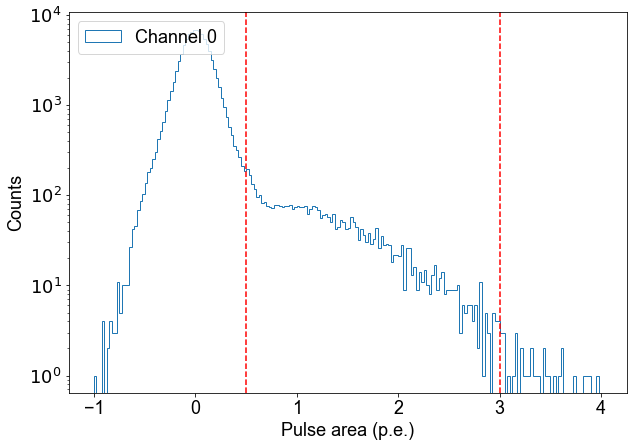

In [67]:
# Inspect the single p.e. spectrum
x.plot_area_spectrum(area_bounds = area_cut_bounds, bins=200, histtype='step', label = 'Channel %d' % channel,
                    range=(-1, 4))
plt.legend()
plt.show()

In [68]:
x.cut_area(area_cut_bounds)

Selected 4191 of 100000 events (4.19 %)


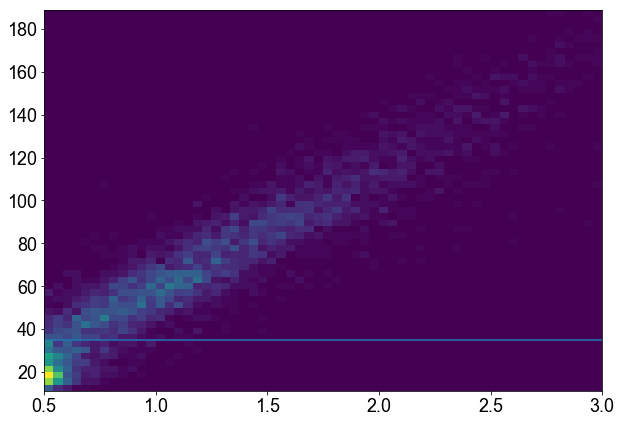

In [69]:
plt.hist2d(x.df['area'], x.df['max'], bins=60)
plt.axhline(min_amplitude)
plt.show()

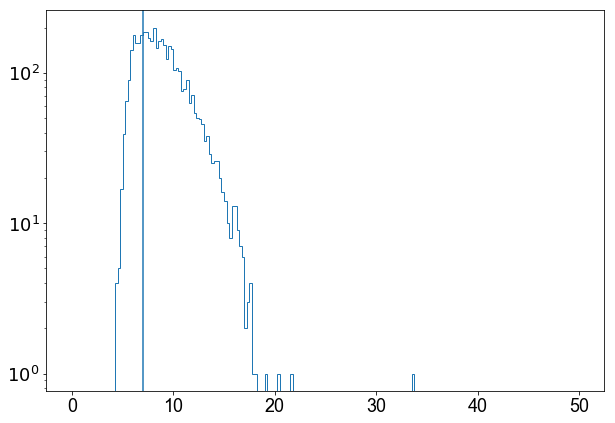

In [70]:
plt.hist(x.df['noise'], bins=200, histtype='step', range=(0, 50))

plt.axvline(noise_max)
plt.yscale('log')
plt.show()

In [71]:
x.cut_max((min_amplitude, 10000))

Selected 3410 of 4191 events (81.36 %)


In [73]:
x.cut_noise(noise_max = 15)

Selected 3315 of 3407 events (97.30 %)


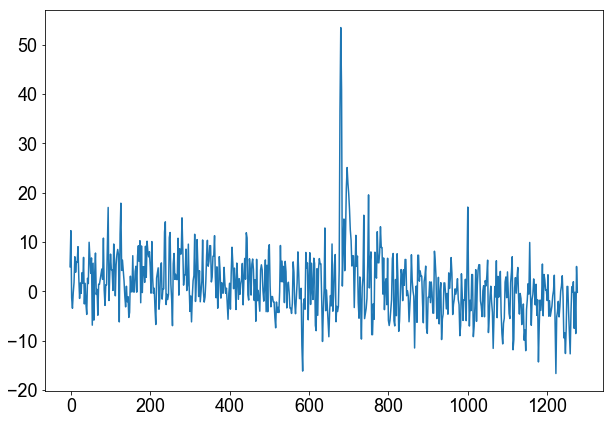

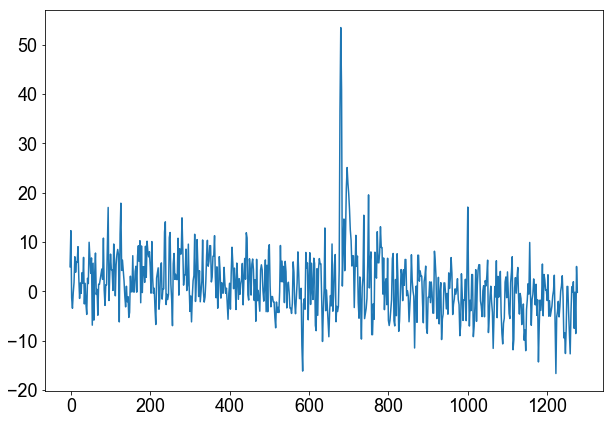

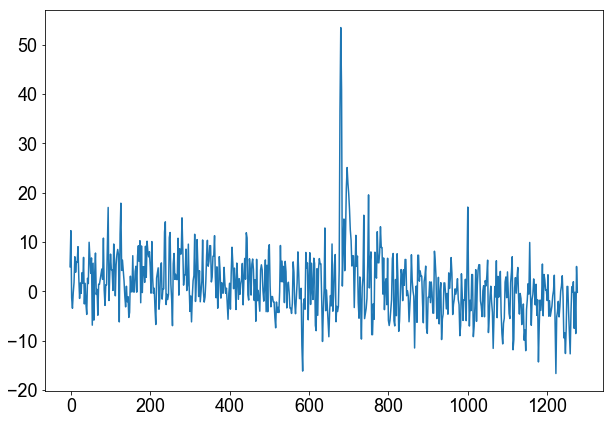

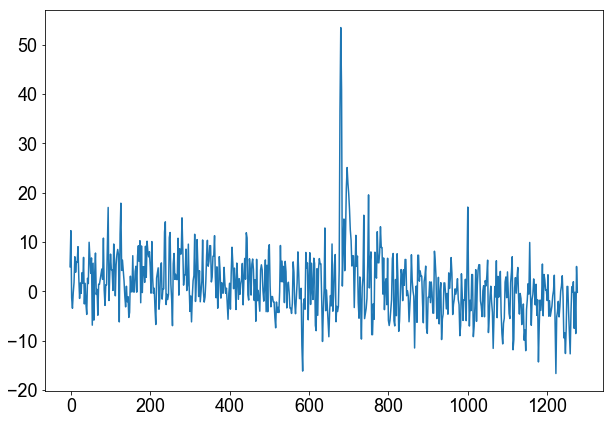

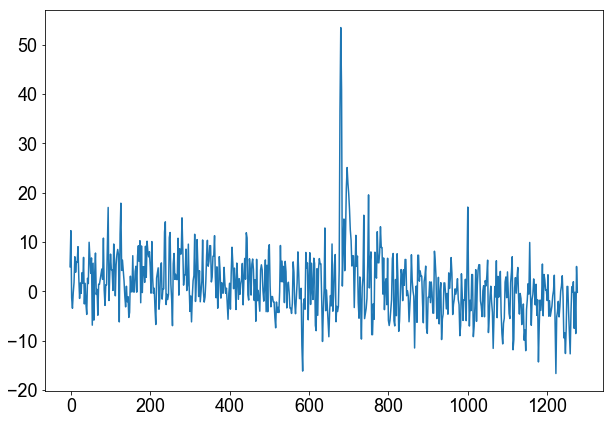

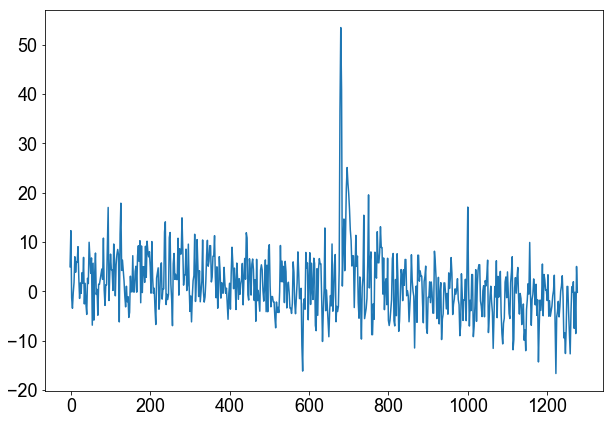

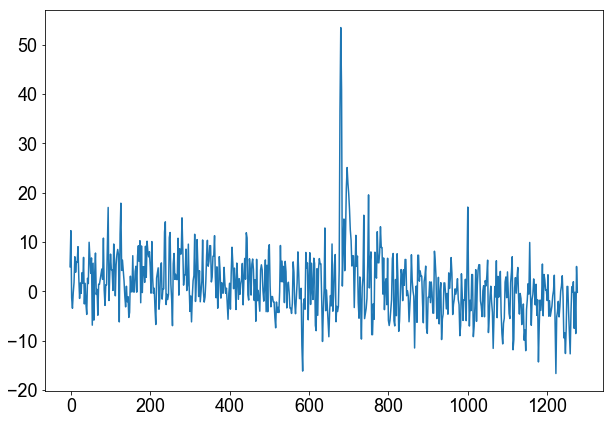

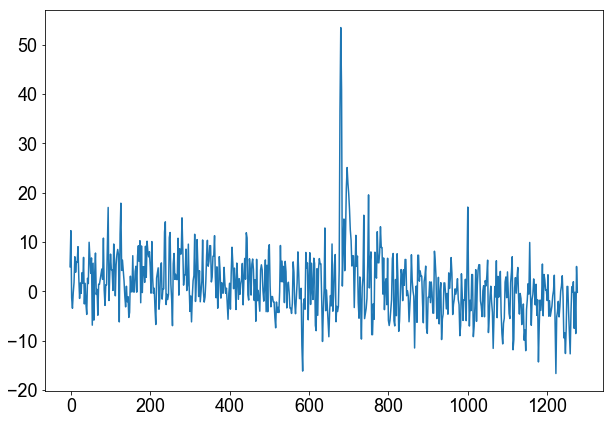

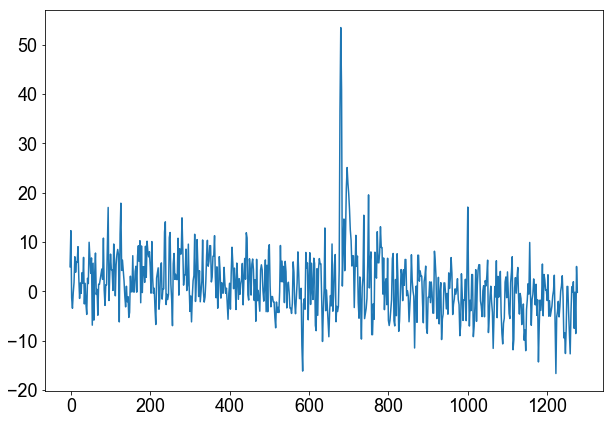

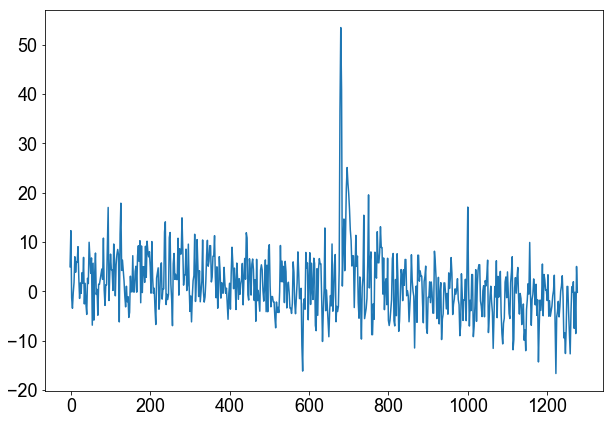

In [75]:
for i in range(10):
    x.plot_waveform(0)
    plt.show()

In [13]:
# To inspect waveforms...
# for i in range(100):
#     x.plot_waveform(0, i)
#     plt.axhline(0, color='black')
#     for _l in area_bounds:
#         plt.axvline(_l * 2)
#     plt.savefig('plots/%d.png' % i)
#     plt.close()

In [77]:
time, pulse = x.get_average_pulse(normalize=True, align_on='max_index', alignment_bin=340)

(-100, 400)

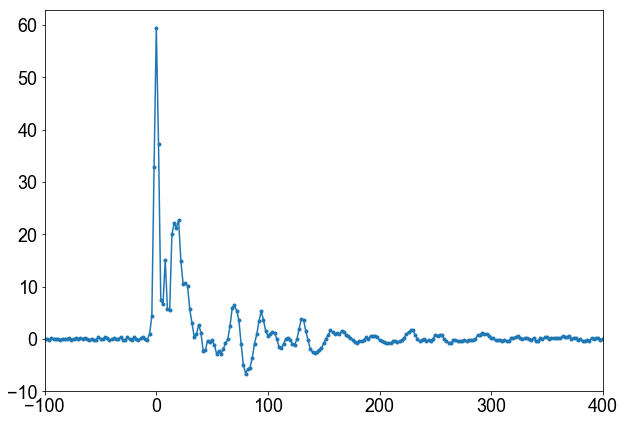

In [78]:
plt.plot(time - 340 * 2, pulse, marker='.')
plt.xlim(-100, 400)

(-10, 10)

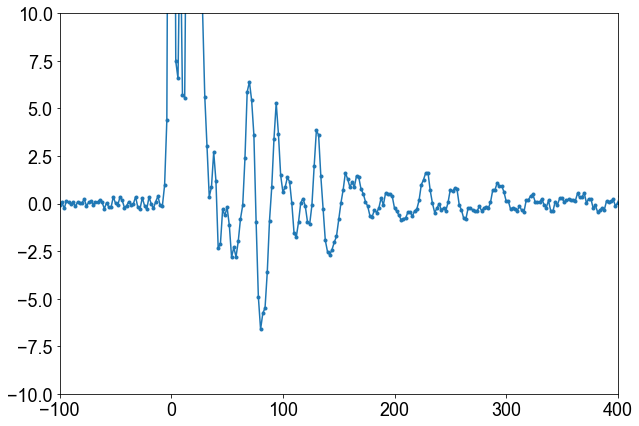

In [80]:
plt.plot(time - 340 * 2, pulse, marker='.')
plt.xlim(-100, 400)
plt.ylim(-10, 10)

In [17]:
pickle.dump(pulse, open('%s_ch%d.pickle' % (dset, channel) , 'wb'))

### Area scan

Selected 2876 of 15643 events (18.4 %)
Selected 3270 of 15643 events (20.9 %)
Selected 2970 of 15643 events (19.0 %)
Selected 2348 of 15643 events (15.0 %)
Selected 1668 of 15643 events (10.7 %)
Selected 1142 of 15643 events (7.3 %)
Selected 665 of 15643 events (4.3 %)
Selected 381 of 15643 events (2.4 %)
Selected 210 of 15643 events (1.3 %)
Selected 113 of 15643 events (0.7 %)


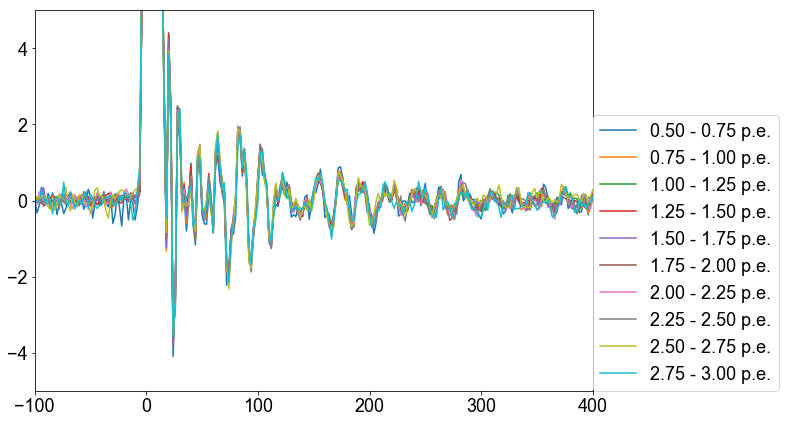

In [26]:
nbins = 11
area_bin_edges = np.linspace(*area_cut_bounds, num=nbins)
for area_min, area_max in zip(area_bin_edges[:-1], area_bin_edges[1:]):
    _x = deepcopy(x)
    _x.cut_area(channel, (area_min, area_max))
    _time, _pulse = _x.get_average_pulse(0, normalize=True, align_on='max_index', alignment_bin=340)
    plt.plot(_time - 340 * 2, _pulse, label='%.2f - %.2f p.e.' % (area_min, area_max))
plt.legend(loc=(1,0))
plt.xlim(-100, 400)
plt.ylim(-5, 5)
plt.show()

### Channel 1 (PMT1)

### To check out:

  * Per dataset
  * For different area slices (Looks good!)
  * Jackknife?
  * FFT